# Step2. Exploratory Data Analysis

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline

import warnings
warnings.simplefilter('ignore')

In [2]:
# Import data
df_wr = pd.read_csv('./data/WRactive_4th.csv')
df_rb = pd.read_csv('./data/RBactive_4th.csv')
df_qb = pd.read_csv('./data/QBactive_4th.csv')

In [3]:
# Drop first column
df_qb = df_qb.drop(columns ='Unnamed: 0',axis=1)
df_wr = df_wr.drop(columns ='Unnamed: 0',axis=1)
df_rb = df_rb.drop(columns ='Unnamed: 0',axis=1)

---

### Feature Engineering and Concatenating

Text(0.5, 1.0, 'ACTIVE Players')

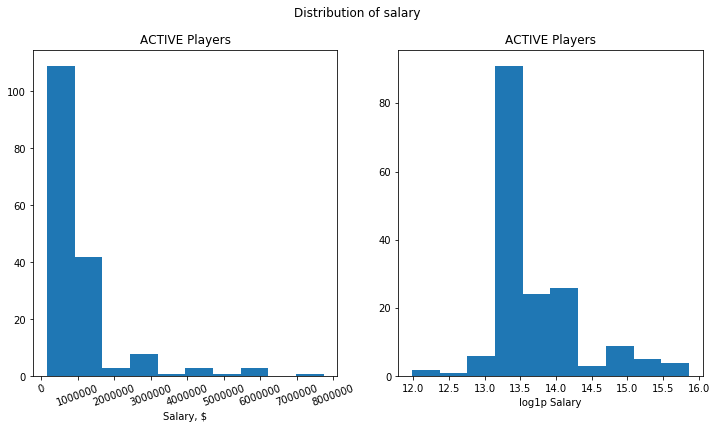

In [4]:
# What's the distribution of salary
plt.figure(figsize=(12,6))

plt.suptitle('Distribution of salary')

plt.subplot(1,2,1)
plt.hist(df_wr['Salary'])
plt.xticks(rotation=20)
plt.xlabel('Salary, $')
plt.title('ACTIVE Players')

plt.subplot(1,2,2)
plt.hist(np.log1p(df_wr['Salary']))
plt.xlabel('log1p Salary')
plt.title('ACTIVE Players')

- Definitely makes sense to do log1p transformation on salary

---

### Normalizing yards and touchdowns into Fantasy Points

In [5]:
# Turning Yards TDs into fantasy points
#<<< [10 yds = 1 point]  and  [1 TD = 4 point]

df_qb['yr1'] = df_qb['Yds_1']/ 10  + df_qb['TD_1']* 4
df_qb['yr2'] = df_qb['Yds_2']/ 10  + df_qb['TD_2']* 4
df_qb['yr3'] = df_qb['Yds_3']/ 10  + df_qb['TD_3']* 4
df_qb['yr4'] = df_qb['Yds_4']/ 10  + df_qb['TD_4']* 4
df_qb['Salary_log1p'] = np.log1p(df_qb['Salary'])

In [6]:
# Turning Yards TDs into fantasy points
#<<< [10 yds = 1 point]  and  [1 TD = 6 point]

df_rb['yr1'] = df_rb['Yds_1']/ 10  + df_rb['TD_1']* 6
df_rb['yr2'] = df_rb['Yds_2']/ 10  + df_rb['TD_2']* 6
df_rb['yr3'] = df_rb['Yds_3']/ 10  + df_rb['TD_3']* 6
df_rb['yr4'] = df_rb['Yds_4']/ 10  + df_rb['TD_4']* 6
df_rb['Salary_log1p'] = np.log1p(df_rb['Salary'])

In [7]:
# Turning Yards TDs into fantasy points
#<<< [10 yds = 1 point]  and  [1 TD = 6 point]

df_wr['yr1'] = df_wr['Yds_1']/ 10  + df_wr['TD_1']* 6
df_wr['yr2'] = df_wr['Yds_2']/ 10  + df_wr['TD_2']* 6
df_wr['yr3'] = df_wr['Yds_3']/ 10  + df_wr['TD_3']* 6
df_wr['yr4'] = df_wr['Yds_4']/ 10  + df_wr['TD_4']* 6
df_wr['Salary_log1p'] = np.log1p(df_wr['Salary'])

---

### Do more manipulations so we could concatenate 3 positions

In [8]:
# Make Columnn that describe posiitons
q = df_qb.shape[0]
df_qb['pos'] = np.asarray(['QB' for _ in range(q)]).reshape(q,1)

r = df_rb.shape[0]
df_rb['pos'] = np.asarray(['RB' for _ in range(r)]).reshape(r,1)

w = df_wr.shape[0]
df_wr['pos'] = np.asarray(['WR' for _ in range(w)]).reshape(w,1)

### Selecting columns to use for X variables in machine learning

In [9]:
# Select columns of interest
samecol = ['Player','pos','draftTeam','draftStat','draftRnd','ht_inch','Wt','dash','Yds_1','TD_1',
          'Yds_2','TD_2','Yds_3','TD_3','Yds_4','TD_4','yr1','yr2','yr3','yr4','Salary','Salary_log1p']
df_qb_new = df_qb[samecol]
df_rb_new = df_rb[samecol]
df_wr_new = df_wr[samecol]

In [10]:
# Concatenate the 3 data frames (positions)
df_new = pd.concat([df_qb_new, df_rb_new, df_wr_new])

---

### Quick check of salaries

In [11]:
# What's the range of salaries?

df_new[ (df_new.Salary == df_new.Salary.min()) | (df_new.Salary == df_new.Salary.max()) ]

,Player,pos,draftTeam,draftStat,draftRnd,ht_inch,Wt,dash,Yds_1,TD_1,...,Yds_3,TD_3,Yds_4,TD_4,yr1,yr2,yr3,yr4,Salary,Salary_log1p
30,Aaron Rodgers,QB,Green Bay Packers,Yes,1,74,223,4.71,65,0,...,218,1,4038,28,6.5,4.6,25.8,515.8,1.489950e+07,16.516838
28,Quincy Wilson,RB,Atlanta Falcons,Yes,7,69,225,4.60,0,0,...,2,0,0,0,0.0,0.0,0.2,0.0,3.052648e+04,10.326383


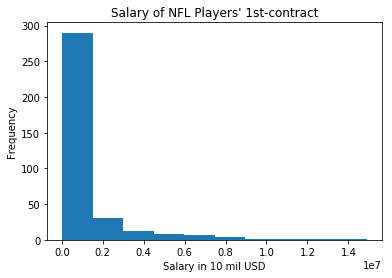

In [18]:
# Plot
df_new['Salary'].plot(kind='hist')
plt.xlabel('Salary in 10 mil USD')
plt.title("Salary of NFL Players' 1st-contract");

In [30]:
# Who made less than $ 250,000?

df_new[df_new['Salary'] < (0.25 * 1e7)].sort_values(by='Salary', ascending=True).head()


,Player,pos,draftTeam,draftStat,draftRnd,ht_inch,Wt,dash,Yds_1,TD_1,...,Yds_3,TD_3,Yds_4,TD_4,yr1,yr2,yr3,yr4,Salary,Salary_log1p
28,Quincy Wilson,RB,Atlanta Falcons,Yes,7,69,225,4.60,0,0,...,2,0,0,0,0.0,0.0,0.2,0.0,30526.484,10.326383
78,Onrea Jones,WR,NaN,No,0,71,202,4.42,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,160020.000,11.983060
57,DeShawn Wynn,RB,Green Bay Packers,Yes,7,70,232,4.47,203,4,...,19,0,0,0,44.3,17.0,1.9,0.0,194666.616,12.179049
36,Justin Jenkins,WR,NaN,No,0,71,213,4.60,0,0,...,0,0,0,0,0.0,0.0,0.0,0.0,220002.323,12.301398
60,Adam Jennings,WR,Atlanta Falcons,Yes,6,69,181,4.44,0,0,...,0,0,0,0,0.0,12.2,0.0,0.0,330315.000,12.707805


In [22]:
# Who made more than $5 million? which is considered exceptionally high for rookies
df_new[df_new['Salary']> (5*1e6)].sort_values(by='Salary', ascending=False).head(10)

,Player,pos,draftTeam,draftStat,draftRnd,ht_inch,Wt,dash,Yds_1,TD_1,...,Yds_3,TD_3,Yds_4,TD_4,yr1,yr2,yr3,yr4,Salary,Salary_log1p
30,Aaron Rodgers,QB,Green Bay Packers,Yes,1,74,223,4.71,65,0,...,218,1,4038,28,6.5,4.6,25.8,515.8,1.489950e+07,16.516838
54,Matt Ryan,QB,Atlanta Falcons,Yes,1,77,228,4.89,3440,16,...,3705,28,4177,29,408.0,379.6,482.5,533.7,1.249875e+07,16.341139
35,Jay Cutler,QB,Denver Broncos,Yes,1,75,226,4.77,1001,9,...,4526,25,3666,27,136.1,429.7,552.6,474.6,1.163056e+07,16.269147
61,Sam Bradford,QB,St. Louis Rams,Yes,1,76,236,4.79,3512,18,...,3702,21,1687,14,423.2,240.4,454.2,224.7,9.675000e+06,16.085056
15,Carson Palmer,QB,Cincinnati Bengals,Yes,1,77,232,4.65,0,0,...,3836,32,4035,28,0.0,361.7,511.6,515.5,8.241750e+06,15.924723
65,Darren McFadden,RB,Oakland Raiders,Yes,1,73,211,4.33,499,4,...,1157,7,614,4,73.9,41.7,157.7,85.4,7.826995e+06,15.873089
149,Mike Williams,WR,Tampa Bay Buccaneers,Yes,4,73,221,4.53,964,11,...,996,9,216,2,162.4,95.1,153.6,33.6,7.740000e+06,15.861912
19,Eli Manning,QB,San Diego Chargers,Yes,1,77,221,4.90,1043,6,...,3244,24,3336,23,128.3,472.2,420.4,425.6,7.694850e+06,15.856062
56,Josh Freeman,QB,Tampa Bay Buccaneers,Yes,1,78,248,4.90,1855,10,...,3592,16,4065,27,225.5,445.1,423.2,514.5,7.177650e+06,15.786483
2,Chad Pennington,QB,New York Jets,Yes,1,75,229,4.81,67,1,...,3120,22,2139,13,10.7,13.2,400.0,265.9,6.898500e+06,15.746815


Note:
- It is difficult to differentiate between players who actually have the same contract on their 4th year and those who got a new contract (higher salary) before their 4th year ends

In [23]:
df_new.columns

Index(['Player', 'pos', 'draftTeam', 'draftStat', 'draftRnd', 'ht_inch', 'Wt',
       'dash', 'Yds_1', 'TD_1', 'Yds_2', 'TD_2', 'Yds_3', 'TD_3', 'Yds_4',
       'TD_4', 'yr1', 'yr2', 'yr3', 'yr4', 'Salary', 'Salary_log1p'],
      dtype='object')

In [24]:
# Select columns to use in model

df_new = df_new[['pos','draftStat','draftRnd','ht_inch','Wt','dash',
                 'yr1', 'yr2', 'yr3', 'yr4', 'Salary_log1p']]

### Encode categoricals


In [25]:
# Turning categoricals into one-hot encoding
df = pd.get_dummies(df_new)

In [26]:
# Reorder column positions in the dataframe

df = df[['draftRnd', 'ht_inch', 'Wt', 'dash', 'yr1', 'yr2', 'yr3', 'yr4',
         'pos_QB', 'pos_RB','pos_WR','draftStat_No', 'draftStat_Yes'] + ['Salary_log1p']]

### Saving dataframe

In [27]:
df.to_csv('./data/Allplayers.csv')

In [34]:
df.head()


,draftRnd,ht_inch,Wt,dash,yr1,yr2,yr3,yr4,pos_QB,pos_RB,pos_WR,draftStat_No,draftStat_Yes,Salary_log1p
0,6,76,211,5.28,0.6,356.3,488.4,454.0,1,0,0,0,1,13.290080
1,6,74,208,4.97,0.0,0.0,238.6,472.5,1,0,0,0,1,13.107759
2,1,75,229,4.81,10.7,13.2,400.0,265.9,1,0,0,0,1,15.746815
3,3,75,222,5.37,1.9,0.0,131.4,5.8,1,0,0,0,1,14.364702
4,2,72,213,4.83,26.1,396.4,254.8,423.9,1,0,0,0,1,14.512511


- Now, we've got a workable dataframe to do machine learning with

---

### Check for linearity among features

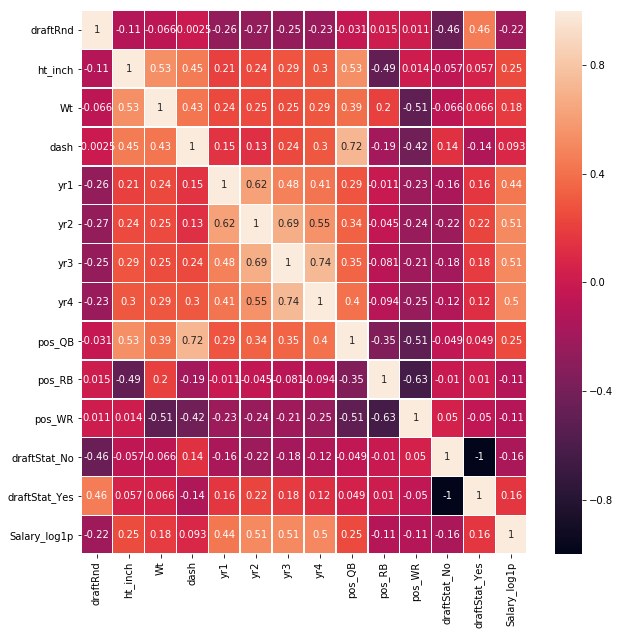

In [29]:
# Quick check of feature and target correlations
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(), annot=True, linewidths=.5, ax=ax);
# fig.savefig('./figures/correlation_heatmap.png')

In [30]:
# Let's just look at performance
selectcol= ['yr1','yr2','yr3','yr4', 'Salary_log1p']
df[selectcol].head()

,yr1,yr2,yr3,yr4,Salary_log1p
0,0.6,356.3,488.4,454.0,13.290080
1,0.0,0.0,238.6,472.5,13.107759
2,10.7,13.2,400.0,265.9,15.746815
3,1.9,0.0,131.4,5.8,14.364702
4,26.1,396.4,254.8,423.9,14.512511


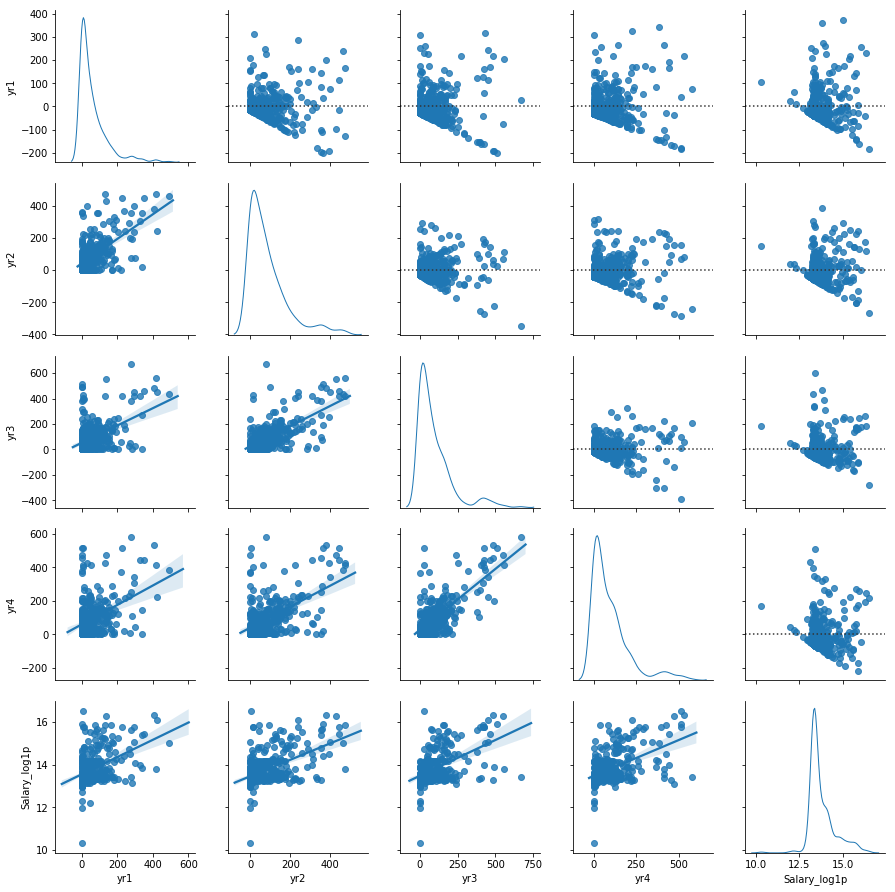

In [31]:
# Pair Plot performance vs salary

g = sns.PairGrid(df.loc[:,selectcol], diag_sharey=False)
g.map_lower(sns.regplot)
g.map_upper(sns.residplot)
g.map_diag(sns.kdeplot, lw=1)


- Looks like we will need to transform some variables before we start using machine learning
- **RED FLAGS**: Players' performance in their initial 4 years are not great. They got plenty of zeros. The distributions are heavily skewed to the right.


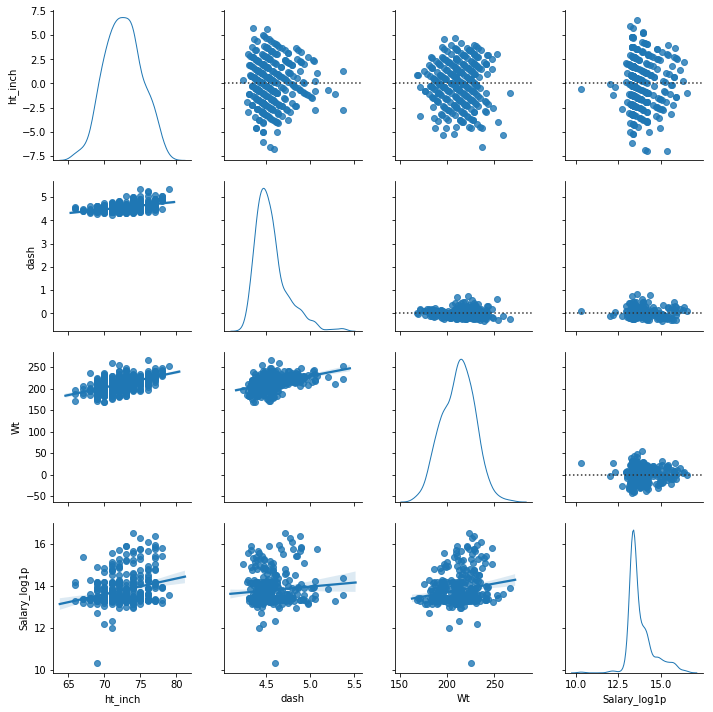

In [32]:
# Pairplot Combine
selectcol2= ['ht_inch','dash','Wt','Salary_log1p']

g = sns.PairGrid(df.loc[:,selectcol2], diag_sharey=False)
g.map_lower(sns.regplot)
g.map_upper(sns.residplot)
g.map_diag(sns.kdeplot, lw=1)


- weak correlations between physiques and salary

---